In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import wget
import scipy.spatial as SS
#from torch_geometric.data import Data
#from torch_geometric.utils import to_networkx
#import torch_geometric.transforms as T
import torch.nn as nn
#from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import networkx as nx
import random

In [2]:
c = 3.*10**8
boxsize = 25.e3

with h5py.File('data/groups_090.hdf5', 'r') as f:
    # Positions, velocities and masses of the halos
    M_h =   f['Group/Group_M_Crit200'][:]*1e10      #Msun/h
    R_h =   f['Group/Group_R_Crit200'][:]/c         #kpc/h
    V_h  =  f['Group/GroupVel'][:]                  #km/s
    V_h =   np.linalg.norm(V_h, axis = 1)
    ID_r =  f['Group/GroupFirstSub'][:] #Contains halos without gals as this number = -1
    ID_h =  np.arange(0, M_h.shape[0], 1, dtype = float) #It is the ID of the halos, to match the gal cat

    # Positions, stellar masses,  of the galaxies
    SM    = f['Subhalo/SubhaloMassType'][:,4]*1e10 #Msun/h
    mags = f['Subhalo/SubhaloStellarPhotometrics'][:]
    SFR = f['Subhalo/SubhaloSFR'][:]*1e10 #(Msun/year)/ (10^10 Msun/h)
    R_g  =  f['Subhalo/SubhaloHalfmassRadType'][:, 4] #kpc/h
    ID_g = np.array(f['Subhalo/SubhaloGrNr']) #Gals IDs

In [3]:
M_h.shape, SM.shape

((20131,), (17176,))

In [4]:
#Removing halos without galaxies
indexes = np.where( ID_r != -1)[0]
M_h = M_h[indexes]
R_h = R_h[indexes]
V_h = V_h[indexes]
ID_h = ID_h[indexes]

ID_h.shape

(13837,)

In [5]:
# Halo catalog
data = np.array( [ M_h, R_h, V_h, ID_h ] ).T
columns = [ 'M_h', 'R_h', 'V_h', 'ID' ] 
halos = pd.DataFrame(data = data, columns = columns)
halos.head(3)

,M_h,R_h,V_h,ID
0,4.500575e+13,0.000002,27.004244,0.0
1,1.912689e+13,0.000001,56.368275,1.0
2,2.011009e+13,0.000001,188.867279,2.0


In [6]:
halos.shape

(13837, 4)

In [7]:
indexes = np.where( SM > 0)[0]
SM = SM[indexes]
mags    = mags[indexes]
SFR     = SFR[indexes]
R_g     = R_g[indexes]
ID_g = ID_g[indexes]

indexes.shape

(2424,)

In [8]:
#g - r
color = mags[:, 4] - mags[:, 5]

In [9]:
#Galaxy catalog
data = np.array( [ SM, R_g, SFR, color, ID_g ] ).T
columns = [ 'SM', 'R_g', 'SFR', 'color', 'ID' ] 
gals = pd.DataFrame(data = data, columns = columns)
gals.head(3)

,SM,R_g,SFR,color,ID
0,4.267894e+11,30.098984,0.000000e+00,0.762205,0.0
1,2.398532e+10,3.347014,1.699688e+10,0.544336,0.0
2,1.551164e+10,4.301775,2.204744e+09,0.513983,0.0


In [10]:
#Converting SFR from the non-forming galaxies to have a SFR equal to a Gaussian distribution
gals['SFR'] = gals['SFR'].replace(0, 1)
gals['SFR'] = np.log10(gals['SFR'])
gals.loc[gals['SFR'] == 0, "SFR"] = np.random.normal(6.4, 0.5, len(gals.loc[gals["SFR"] == 0]))

In [11]:
df = pd.merge(left = halos, right = gals, left_on = 'ID', right_on = 'ID')
df.shape

(2424, 8)

In [12]:
df['M_h'] = np.log10(df['M_h'])
df['R_h'] = np.log10(df['R_h'])
df['V_h'] = np.log10(df['V_h'])

Text(0.5, 0, 'V_h')

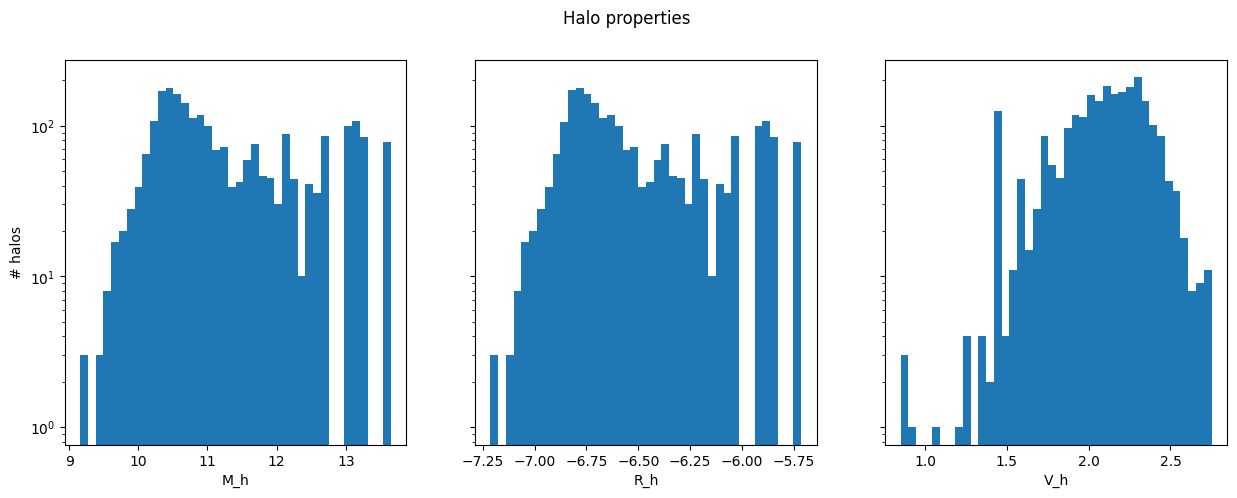

In [13]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharey = True, dpi = 100)

fig.suptitle('Halo properties')

axs[0].hist(df['M_h'], bins = 40)
axs[0].set_yscale('log')
axs[0].set_xlabel('M_h')
axs[0].set_ylabel('# halos')

axs[1].hist(df['R_h'], bins = 40)
axs[1].set_yscale('log')
axs[1].set_xlabel('R_h')

axs[2].hist(df['V_h'], bins = 40)
axs[2].set_yscale('log')
axs[2].set_xlabel('V_h')

In [14]:
df['SM'] = np.log10(df['SM'])

Text(0.5, 0, 'SFR')

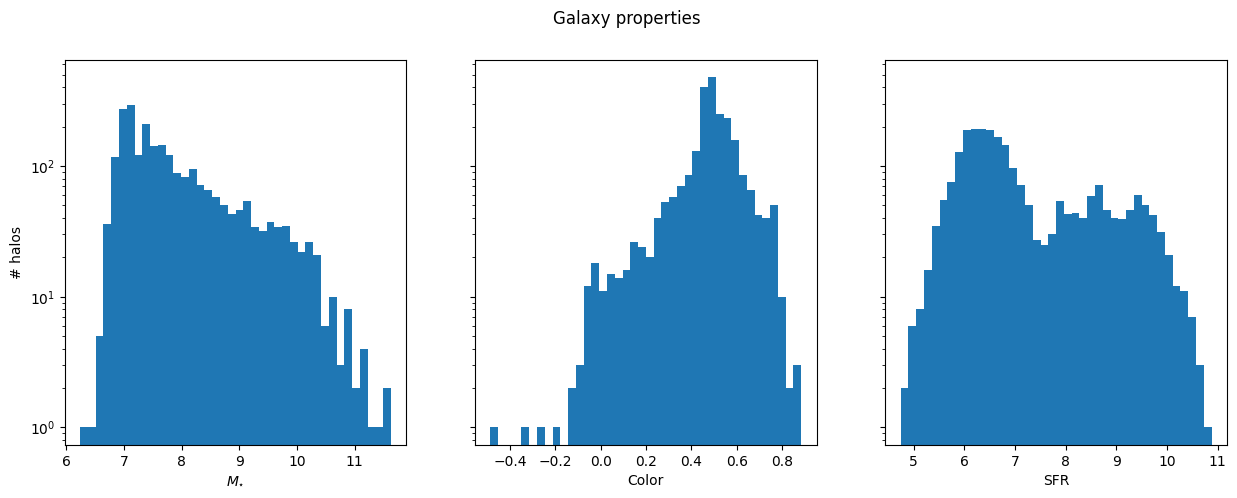

In [15]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharey = True, dpi = 100)

fig.suptitle('Galaxy properties')

axs[0].hist(df['SM'], bins = 40)
axs[0].set_yscale('log')
axs[0].set_xlabel(r'$M_{\star}$')
axs[0].set_ylabel('# halos')

axs[1].hist(df['color'], bins = 40)
axs[1].set_yscale('log')
axs[1].set_xlabel('Color')

axs[2].hist(df['SFR'], bins = 40)
axs[2].set_yscale('log')
axs[2].set_xlabel('SFR')